https://causalnex.readthedocs.io/en/latest/03_tutorial/03_tutorial.html

## Objectives

1. Learn structural causal model from data
2. Modify structure using domain knowledge
3. Model structural relationship with a Bayesian Network
4. Fit Bayesian Network to data -> estimate conditional probability distributions
5. Make prediction using learned model
6. Evaluate prediction model quality
7. Perform model inference
8. Evaluate effect of interventions using Do-Calculus

### Data prep

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv('../data/student-por.csv', delimiter=';')

In [6]:
# Drop sensitive features
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
df = df.drop(columns=drop_col)

In [5]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Learn structural causal model from data

In [12]:
from causalnex.structure.notears import from_pandas

In [10]:
# Make data numeric - NOTEARS structure learning algo requires this
struct_data = df.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

In [11]:
struct_data.head()

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


### Learn it 

In [13]:
# Learn it
sm = from_pandas(struct_data)

### Visualise it

In [19]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

/home/alex/anaconda3/envs/causalnex/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'address', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


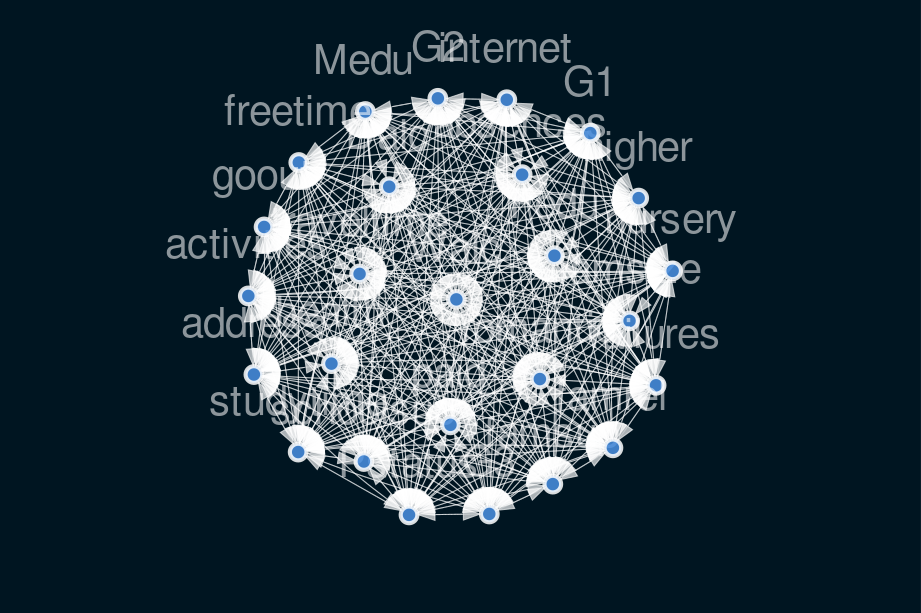

In [21]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

Applying thresholding to weaker edges helps clean up structure.

/home/alex/anaconda3/envs/causalnex/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'address', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/alex/anaconda3/envs/causalnex/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'address', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


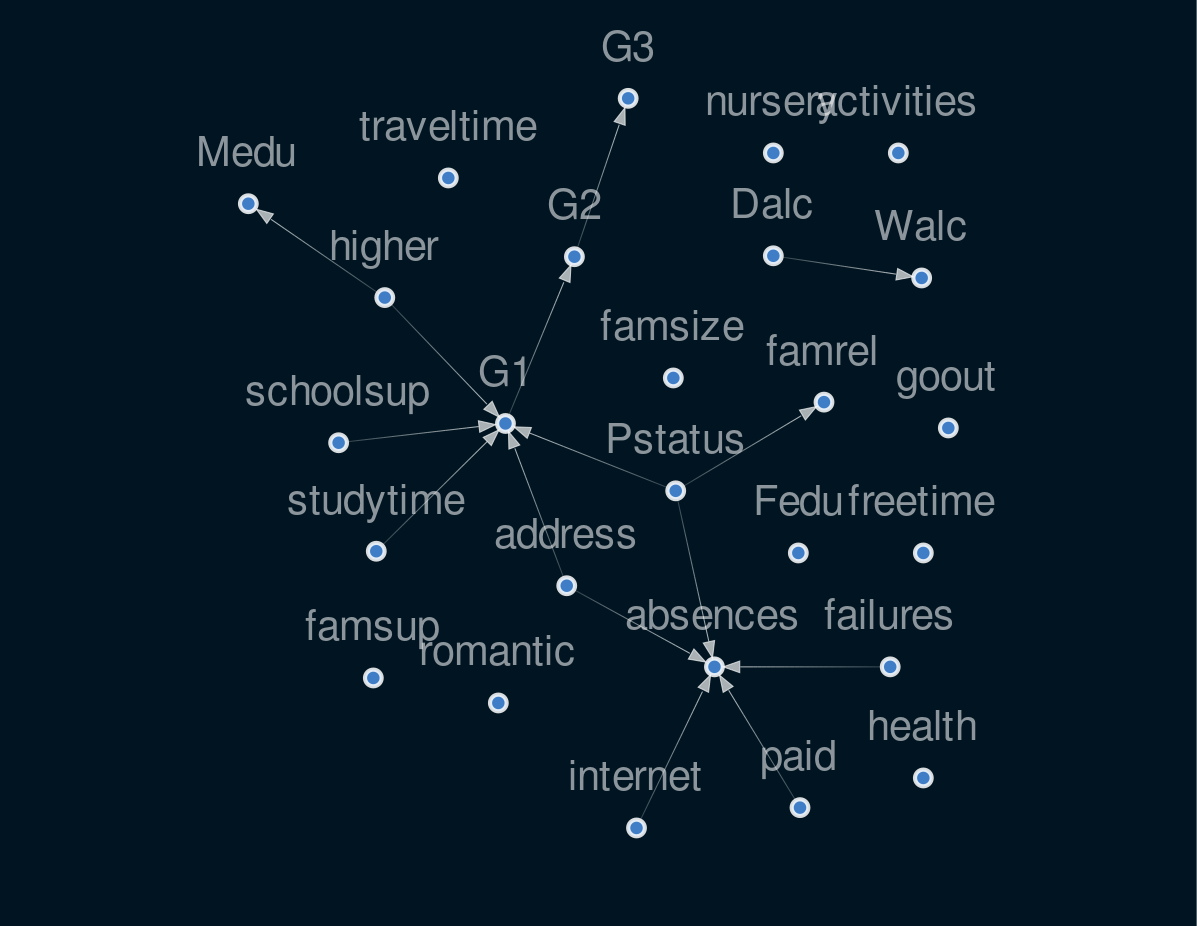

In [26]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

Some interesting observations

Number of school absences are affected by:
 
 1. Internet access at home
 2. Extra paid classes within the course subject
 3. Number of past class failures
 4. Parent cohabitation status (together or apart)
 5. Urban or rural address
 
 
First period grades are affected by:
 
 1. Urban or rural address
 2. Parent cohabitation status (together or apart)
 3. Extra educational support
 4. Weekly study time
 5. Wants to take higher education
 
 
Workday alcohol consumption affects weekend alcohol consumption (wow)
 
Grades per period have a sequential effect.

Wants to take higher education affects mother's education, which is wrong. Could be the other way round.

## Modify structure with domain knowledge

### Re-run structure learning by adding constraints for infeasible relationships

In [27]:
sm = from_pandas(struct_data, tabu_edges=[("higher", "Medu")], w_threshold=0.8)

/home/alex/anaconda3/envs/causalnex/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'address', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/alex/anaconda3/envs/causalnex/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'address', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


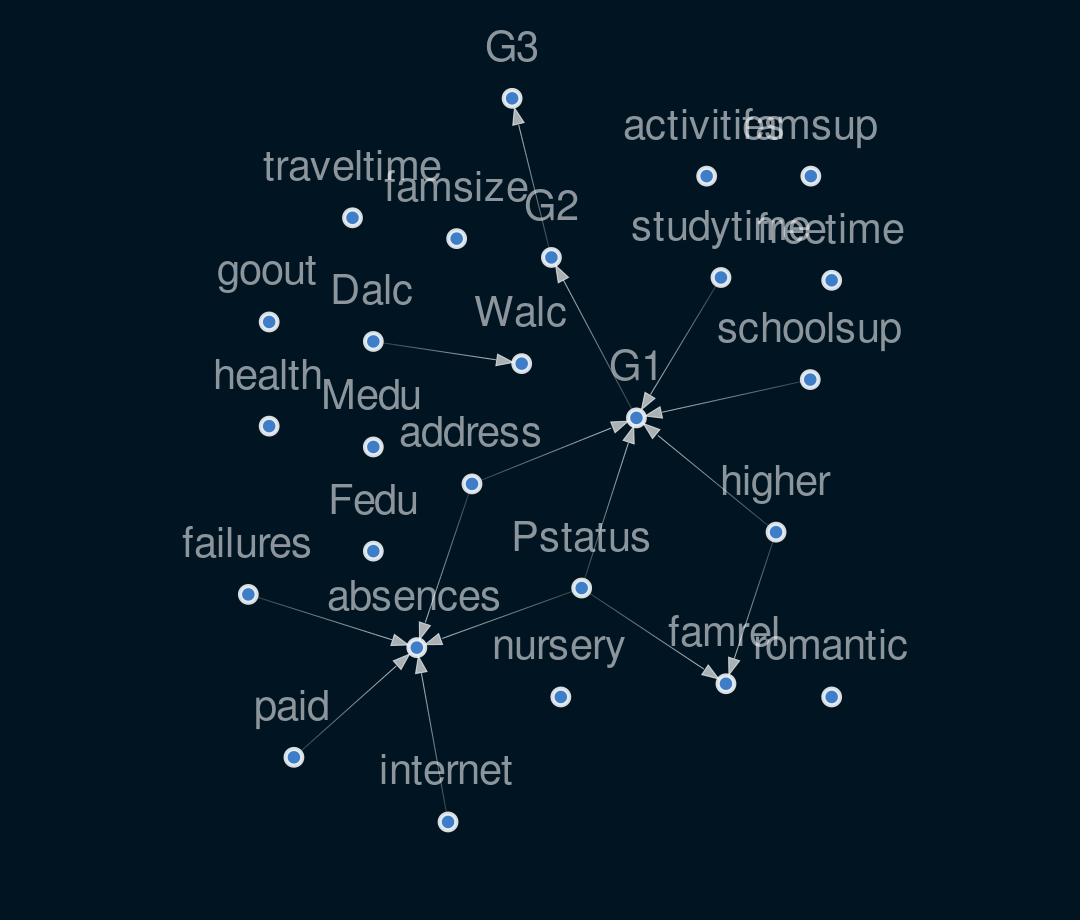

In [28]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

### Incorporate more domain knowledge

In [29]:
# Number of past class failures may affect grade
sm.add_edge("failures", "G1")
# Parental cohabitation shouldn't affect grade
sm.remove_edge("Pstatus", "G1")
# Rural or urban address shouldn't affect grade
sm.remove_edge("address", "G1")

/home/alex/anaconda3/envs/causalnex/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'address', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/alex/anaconda3/envs/causalnex/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'address', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


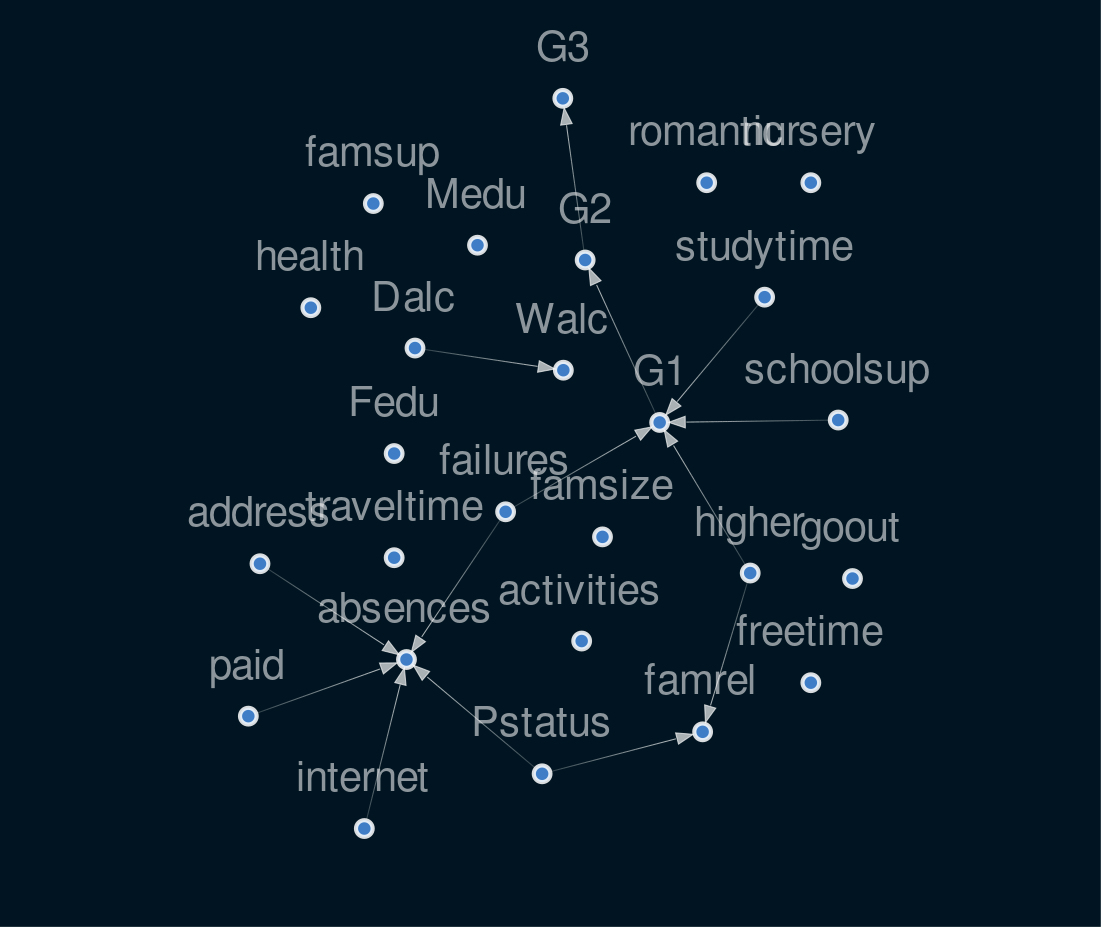

In [30]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

We now have 2 subgraphs. Let's retrieve the largest one.

/home/alex/anaconda3/envs/causalnex/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'address', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
/home/alex/anaconda3/envs/causalnex/lib/python3.7/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: node 'address', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


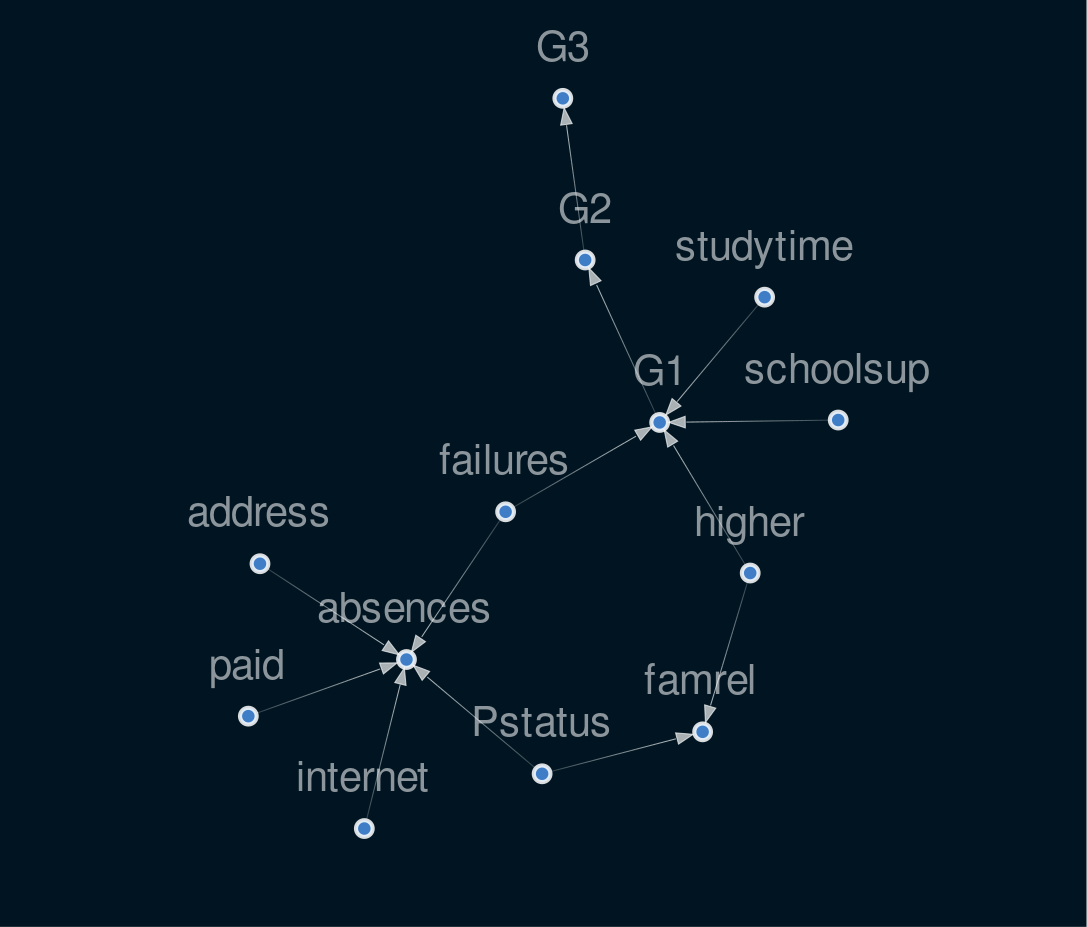

In [31]:
sm = sm.get_largest_subgraph()

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename = "./structure_model.png"
viz.draw(filename)
Image(filename)

## Model structural relationship with a Bayesian Network

In [32]:
from causalnex.network import BayesianNetwork

In [33]:
bn = BayesianNetwork(sm)